In [1]:
import pickle  
import networkx as nx
import random
import numpy as np
import copy
import pandas as pd
import itertools
import math
import ast #将字符串转化为元组
from collections import Counter
from Motif_structures import * #轨道度结构
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from itertools import combinations
import os.path
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split #
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

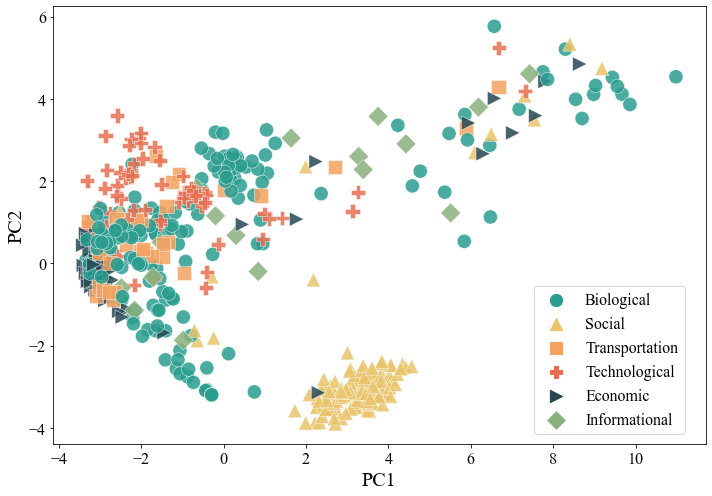

In [9]:
# PCA visualization for SHAP values
# Data preparation
shap_values_no_short =  pd.read_csv('./results/shap_values_no_sort.csv',index_col = 0)
domain_subdomain_list = list(shap_values_no_short.loc['domain'])
domain_list = [x.split('/')[0] for x in domain_subdomain_list]  # Remove subdomain, keep only the domain
pca_data = shap_values_no_short.iloc[:-1]  # Remove the 'domain' row
pca_data = pca_data.T
data = np.array(pca_data)
labels = np.array(domain_list)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Plot PCA graph
custom_palette = ['#2a9d8f', '#e9c46a', '#f4a261', '#e76f51', '#264653', '#8ab17d']
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=principal_components[:, 0], y=principal_components[:, 1],
    hue=labels, style=labels,
    palette=custom_palette,  # Directly use the custom color list
    s=200,  # Increased size of markers
    alpha=0.85, edgecolor='w', linewidth=0.5,
    markers=['o', '^', 's', 'P', '>', 'D']
)
# plt.title('PCA for Domains of Networks', fontsize=20, fontweight='bold')
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.tick_params(axis='x', labelsize=16)  # Set x-axis tick label size
plt.tick_params(axis='y', labelsize=16)  # Set y-axis tick label size

# Customize the legend
lgnd = plt.legend(fontsize='16', loc='upper right', bbox_to_anchor=(0.98, 0.38))
for handle in lgnd.legendHandles:
    handle.set_sizes([150])  # Increase legend marker size

# Ensure the layout doesn't cut off elements
plt.tight_layout()

plt.savefig('./figures/domain_analysis_PCA.pdf', dpi=700, bbox_inches='tight')
plt.show()


In [36]:
shap_values =  pd.read_csv('./results/shap_values_domain.csv',index_col = 0)
Biological_shap = shap_values.loc[:, shap_values.loc['domain'].str.contains('Biological')]
Social_shap = shap_values.loc[:, shap_values.loc['domain'].str.contains('Social')]
Economic_shap = shap_values.loc[:, shap_values.loc['domain'].str.contains('Economic')]
Social_top1 = Social_shap.loc['Top1']
Social_top1_features = []
for i in Social_top1:
    tuple_value = ast.literal_eval(i)
    Social_top1_features.append(tuple_value[0])
count = Counter(Social_top1_features)
total_count = sum(count.values())
tuple_list = [(key, count, round(count / total_count, 4)) for key, count in count.items()]
sorted_tuple_list = sorted(tuple_list, key=lambda x: x[1], reverse=True)
sorted_tuple_list


[('M2', 113, 0.9113),
 ('N7', 3, 0.0242),
 ('M5', 2, 0.0161),
 ('N6', 1, 0.0081),
 ('M12', 1, 0.0081),
 ('M11', 1, 0.0081),
 ('M9', 1, 0.0081),
 ('M4', 1, 0.0081),
 ('M3', 1, 0.0081)]

In [37]:
domains = ['Biological', 'Social','Transportation','Technological','Economic','Informational']
all_data_dict = []
draw_need_features = []
for domain in domains:
    domain_shap = shap_values.loc[:, shap_values.loc['domain'].str.contains(domain)]
    top1 = domain_shap.loc['Top1']
    top1_features = [] 
    for i in top1:
        tuple_value = ast.literal_eval(i)
        top1_features.append(tuple_value[0])
    count = Counter(top1_features)
    total_count = sum(count.values())
    tuple_list = [(key,round(count / total_count, 4)) for key, count in count.items()]
    tuple_list = sorted(tuple_list, key=lambda x: x[1], reverse=True)
    dict_data = dict(tuple_list)
    draw_need_features.extend(list(dict_data.keys()))
    all_data_dict.append(dict_data)
draw_need_features = list(set(draw_need_features))

In [38]:
color2 = ["#ffc971",  "#ffb627",  "#ff9505",  "#f35b04",  "#941b0c"]
color1 = ['#E0F7FA', '#B3E5FC', '#7EA7D8', '#91a6ff', '#03A9F4', '#48cae4', '#e7bbe3', '#2541b2', '#5e4ae3']
color_map = {}
i = 0
j = 0
for key in all_keys:
    if key.startswith('M'):
        color_map[key] = color1[i]
        i+=1
    else:
        color_map[key] = color2[j]
        j+=1

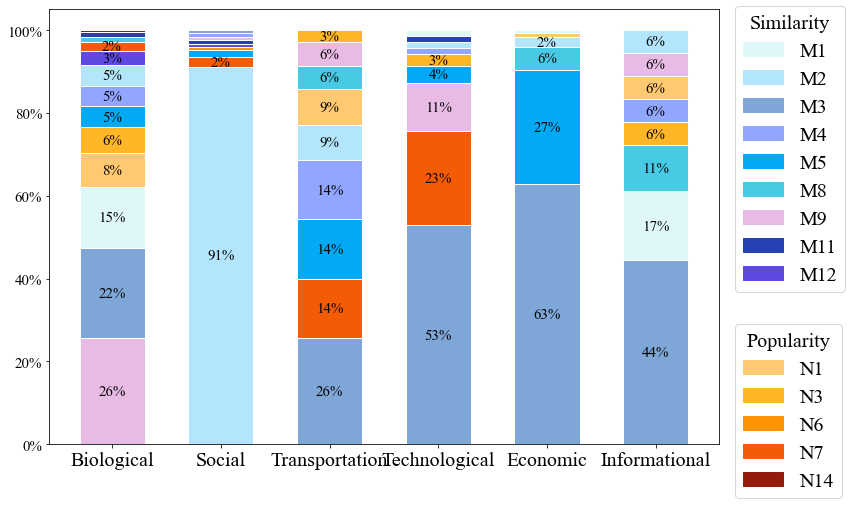

In [39]:
# Initialize subplots
fig, ax = plt.subplots(figsize=(12, 8))

def to_percent(y, position):
    return f"{100 * y:.0f}%"
formatter = FuncFormatter(to_percent)
direct = ['right', 'right', 'left']

def plot_stacked_bar(ax, data, position, label, color_map):
    # Sort the items by value in descending order
    sorted_items = sorted(data.items(), key=lambda item: item[1], reverse=True)
    bottom = 0  # Start the first bar at 0
    a = 1
    for key, value in sorted_items:
        ax.bar(position, value, color=color_map[key], edgecolor='white', width=0.6, bottom=bottom, label=key if bottom == 0 else "")
        text_position = bottom + value / 2  # 添加文字
        if value >= 0.02:
            ax.text(position, text_position, f'{value:.0%}', ha='center', va='center', color='black', fontsize=15)
        bottom += value

# Plotting stacked bars for each dataset
plot_stacked_bar(ax, all_data_dict[0], 0, 'First Dataset', color_map)
plot_stacked_bar(ax, all_data_dict[1], 1, 'Second Dataset', color_map)
plot_stacked_bar(ax, all_data_dict[2], 2, 'Third Dataset', color_map)
plot_stacked_bar(ax, all_data_dict[3], 3, 'Fourth Dataset', color_map)
plot_stacked_bar(ax, all_data_dict[4], 4, 'Five Dataset', color_map)
plot_stacked_bar(ax, all_data_dict[5], 5, 'Six Dataset', color_map)

# Set the x-ticks to be the names of the domains
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['Biological', 'Social','Transportation','Technological','Economic','Informational'], fontsize=20)# rotation=-20
# Formatting y-axis ticks
ax.yaxis.set_major_formatter(formatter)
plt.gca().set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=15)

# Creating the legend manually for 'M' starting features
handles_M = [plt.Rectangle((0, 0), 1, 1, color=color_map[key]) for key in all_keys if key.startswith('M')]
labels_M = [key for key in all_keys if key.startswith('M')]
legend_M = ax.legend(handles_M, labels_M, title="Similarity", bbox_to_anchor=(1.01, 1.03), loc='upper left', fontsize=20)
legend_M.get_title().set_fontsize(20)  # Set legend title font size

# Creating the legend manually for other features
handles_others = [plt.Rectangle((0, 0), 1, 1, color=color_map[key]) for key in all_keys if not key.startswith('M')]
labels_others = [key for key in all_keys if not key.startswith('M')]
legend_others = ax.legend(handles_others, labels_others, title="Popularity", bbox_to_anchor=(1.01, 0.3), loc='upper left', fontsize=20)
legend_others.get_title().set_fontsize(20)  # Set legend title font size

# Combine both legends into a single legend
plt.gca().add_artist(legend_M)
plt.savefig('./figures/domain_anaysis_top1_features.pdf',dpi=700,bbox_inches='tight')
# Show the plot
plt.show()

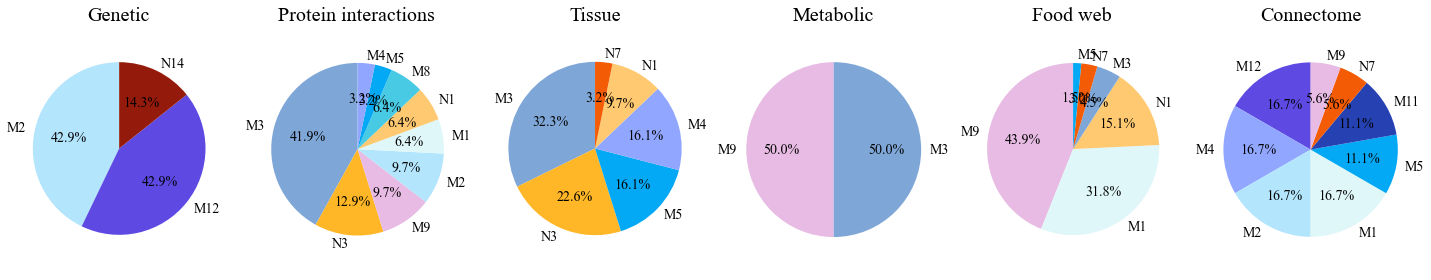

In [41]:
# Define the domains
domains = ['Biological', 'Social', 'Economic', 'Technological', 'Informational', 'Transportation']
Biological_dict = {}

# Loop through the domains, focusing on the Biological domain
for domain in domains[:1]:
    domain_shap = shap_values.loc[:, shap_values.loc['domain'].str.contains(domain)]
    sub_domain_name = list(set(domain_shap.loc['domain']))
    sub_domain_names = [x.split('/')[1] for x in sub_domain_name]
    
    # Loop through each sub-domain
    for sub in sub_domain_name:
        sub_domain_shap = domain_shap.loc[:, domain_shap.loc['domain'] == sub]
        
        top1 = sub_domain_shap.loc['Top1']
        top1_features = []  # Store only feature names, not their values
        for i in top1:
            tuple_value = ast.literal_eval(i)
            top1_features.append(tuple_value[0])
        
        # Count feature occurrences
        count = Counter(top1_features)
        total_count = sum(count.values())
        
        # Create a list of tuples containing feature name, count, and percentage
        tuple_list = [(key, count, round(count / total_count * 100, 2)) for key, count in count.items()]
        sorted_tuple_list = sorted(tuple_list, key=lambda x: x[1], reverse=True)
        
        # Store the sorted list in the dictionary
        Biological_dict[sub] = sorted_tuple_list

import matplotlib.pyplot as plt
sub_domain = ['Genetic', 'Protein interactions', 'Tissue', 'Metabolic', 'Food web', 'Connectome']
# Assume Biological_dict is defined and contains the needed data
color_dict = color_map 

# Create a figure and 6 subplots
fig, axs = plt.subplots(1, 6, figsize=(20, 4))  # One row and six columns

# Function to format pie chart percentages
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        # Return only the percentage
        return '{p:.1f}%'.format(p=pct)
    return my_autopct

# Loop through each sub-domain and create pie charts
for i in range(6):
    data = Biological_dict['Biological/' + sub_domain[i]]
    labels = [x[0] for x in data]
    sizes = [x[2] for x in data]
    quantities = [x[1] for x in data]  # Count data
    colors = [color_dict[label] for label in labels]  # Assign colors for each label

    # Draw pie chart
    axs[i].pie(sizes, labels=labels, colors=colors, autopct=make_autopct(quantities), startangle=90, textprops={'fontsize': 14})
    axs[i].set_title(sub_domain[i], fontsize=20)
    axs[i].axis('equal')  # Ensure the pie chart is circular

# Show the plot
plt.tight_layout()
plt.savefig('./figures/domain_analysis_bio_subdomain.pdf', dpi=700, bbox_inches='tight')
plt.show()


